# TalTech'i programmeerimise ainete Discordi tekstide analüüs

#### Sisukord:
- Korpuse kirjeldus
- Andmete hankimine
- Andmete töötlemine
- Kasutatud meetodid
- Teksti parsimine
- Erinevad parsimise konfiguratsioonid
- Kvantitatiivsed mõõtmed
- TextRank analüsaator
- Teemade klassifitseerimine

#### Korpuse kirjeldus 2020. detsembri seisuga:
- Korpuses on nelja semestri jagu tekste, kus on 2 Püütoni algkursuse ning 2 Java põhikursuse serverit, mida kasutatakse õppetöö läbi viimiseks.
- Serveris on umbes vähemalt 30 ülesande kanalit, 10 informatiivset kanalit ning 10 fun kanalit.
- Nädalas pannakse üles vähemalt 2 ülesannet. Kokku on nädalaid vähemalt 15.
- Kood on lastud läbi analüsaatori: https://github.com/envomp/valence-analyzer
- Korpuses on ligikaudu 3 miljonit sõna.

#### Andmete hankimine:
- Andmete hankeks kasutati Discordi avalikku API peale kirjutatud .net wrapperit, mida jooksutasin docker konteineris ja mountisin failisüsteemis õigesse kohta 
- Kood ning andmete struktuur on kirjeldatud: https://github.com/envomp/discord-data-fetcher 

#### Andmete töötlemine:
- Andmed on töödeldud CachedRunneri abil, millele saab sisestada konfiguratsiooni.
- CountConfiguration, mis loeb kokku sõnade kordused ning teksti alatooni emotsioonid.
- ConcatConfiguration, mis muudab teksti JSON formaadist string kujule.
- Lisaks on kirjutatud TextRank analüsaator ning Kvantitatiivsete mõõdikute eraldaja.
- Koodid on saadaval: https://github.com/envomp/discord-data-aggregator/tree/master/notebook

#### Kasutatud meetodid:
- API requestide abil kanalite sisu hankimine
- Andmete eeltöötlemine (algtüve võtmine, sõnade filtreerimine)
- Meelsusanalüüs
- Kvantitatiivsed mõõdikud (loetavus, ametlikkus ja informatiivsus)
- Võtmesõnade ekstrahheerimine
- Sisukokkuvõtete genereerimine
- Võtmesõnade ning sisukokkuvõtete klasterdamine (TF-IDF)

#### CachedRunner
CachedRunner kasutab antud konfiguratsiooni, et andmed ära töödelda ning Pandas andmestruktuurina tagastada. Nagu ka nimi ütleb, et vastused salvestatakse ära, et järgmine kord on nende andmete pärimine kiirem. CachedRunner tagastab sama andmestiku mitme erineva grupeeringuga:
- aastati
- ülesanneti
- ülesannete grupeeringuti
- kõik eraldi
- kõik koos

In [23]:
%%capture
%load_ext autoreload
%autoreload 2
from concat_configuration import ConcatConfiguration
from count_configuration import CountConfiguration
from textrank_analyzer import TextRankAnalyzer
from quantitative_metrics import QuantitativeMetrics
from cached_runner import CachedRunner
from IPython.display import display
import pandas as pd

#### CountConfiguration

CountConfiguration loeb kokku sõnade kordused ning teksti emotsionaalse alatooni

In [2]:
%%capture
count_configuration = CountConfiguration()
count_runner = CachedRunner(count_configuration)
count_matrixes = count_runner.get_datasets(fresh=False, filter_function=count_configuration.all_words_have_context)

count_all = count_matrixes[0]
count_group_year = count_matrixes[1]
count_year_channels = count_matrixes[2]
count_flat = count_matrixes[3]
count_group_category = count_matrixes[4]

In [3]:
display(count_all)

,group,group_members,total_words,in_a_row,count_0,repetitions_0,count_1,repetitions_1,count_2,repetitions_2,count_3,repetitions_3,count_4,repetitions_4,count_5,repetitions_5,count_6,repetitions_6,count_7,repetitions_7,count_8,repetitions_8,count_9,repetitions_9,valence_only_negative,valence_mostly_negative,valence_only_neutral,valence_mostly_neutral,valence_only_mixed,valence_mostly_mixed,valence_only_positive,valence_mostly_positive
0,all,"['EX / ex01-id-code', 'EX / ex02-cpu', 'EX / e...",3175069,1,mina,80840,https,6513,kadri,5842,test,5239,kord,4885,ülesanne,4623,list,3613,kood,3371,aasta,3302,õige,2911,1625447,29681,746658,38954,0,125232,587919,20364
1,all,"['EX / ex01-id-code', 'EX / ex02-cpu', 'EX / e...",3175069,2,sebastian sõeruer,1536,tere hommikune,926,eelmine aasta,507,mina kood,394,järgmine nädal,272,järgmine aasta,250,järgmine kord,182,õige vastus,174,mina hetk,161,tere hommik,159,1625447,29681,746658,38954,0,125232,587919,20364
2,all,"['EX / ex01-id-code', 'EX / ex02-cpu', 'EX / e...",3175069,3,blacklargesquare |||| blacklargesquare,34,|||| blacklargesquare ||||,25,sebastian sõeruer mina,23,mina eelmine aasta,22,blank line require,20,faile with message,19,testing faile with,19,mina kood pilk,18,require between summary,17,between summary line,17,1625447,29681,746658,38954,0,125232,587919,20364
3,all,"['EX / ex01-id-code', 'EX / ex02-cpu', 'EX / e...",3175069,4,|||| blacklargesquare |||| blacklargesquare,25,blacklargesquare |||| blacklargesquare ||||,25,testing faile with message,19,require between summary line,17,blank line require between,17,line require between summary,17,maximum recursion depth exceede,15,code contains scenario that,9,cannot find symbo symbol,9,your code contains scenario,9,1625447,29681,746658,38954,0,125232,587919,20364


#### Hinnang: 
- Osad inimesed on väga aktiivsed, et nende nimed on isegi top sõnade ning fraaside hulgas.
- Tihti esinevad vead on ka nähtaval, mis tähendab, et programmeerimisest räägitakse palju.
- Väga palju räägitakse eelmistest ning järgmistest perioodidest. 

In [33]:
display(count_group_year.loc[count_group_year['in_a_row'] == 1])

,group,group_members,total_words,in_a_row,count_0,repetitions_0,count_1,repetitions_1,count_2,repetitions_2,count_3,repetitions_3,count_4,repetitions_4,count_5,repetitions_5,count_6,repetitions_6,count_7,repetitions_7,count_8,repetitions_8,count_9,repetitions_9,valence_only_negative,valence_mostly_negative,valence_only_neutral,valence_mostly_neutral,valence_only_mixed,valence_mostly_mixed,valence_only_positive,valence_mostly_positive
4,Java 2020,"['ex / ex01-idcode', 'ex / ex02-webbrowser', '...",59749,1,mina,1199,test,270,ülesanne,230,https,146,java,121,kood,118,punkt,114,meetod,113,kord,107,nädal,107,24813,1067,16879,1487,0,3850,10767,883
12,Python 2020,"['EX / ex01_cashier', 'EX / ex02_cypher', 'EX ...",517998,1,mina,11320,ülesanne,1987,list,1452,test,1325,funktsioon,1251,https,1163,kord,1124,kood,1057,viga,940,näide,801,215392,11683,132377,13318,0,46288,90587,8260
0,java 2019,"['EX / ex01-id-code', 'EX / ex02-cpu', 'EX / e...",1841005,1,mina,52862,kadri,4730,https,4112,kord,2318,aasta,2230,tere,2099,piret,2021,sebastian,2005,laps,1991,päev,1949,1052423,6698,398508,5217,0,23791,350638,3186
8,python 2019,"['EX / ex01', 'EX / ex02', 'EX / ex03_idcode',...",756317,1,mina,15459,test,2259,ülesanne,1500,list,1471,faile,1377,kord,1336,kood,1187,funktsioon,1176,https,1092,kadri,944,332819,10233,198894,18932,0,51303,135927,8035


#### Hinnang: 
- Java 2019 kanal on ebaproportsionaalselt suur ning Java 2020 on ebaproportsionaalselt väika. 2019 aasta kanalis on endiselt aktiivne arutelu mitte programmeerimise teemadel, ning seetõttu ka nimesi palju seal 

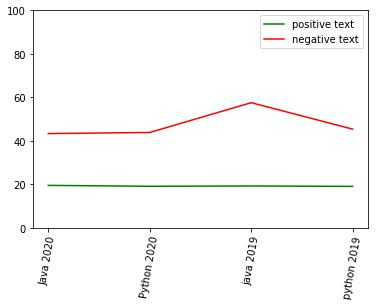

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

def get_axis_for_emotion(emotion, df):
    groups = set()
    x = []
    y = []
    for index, row in df.iterrows():
        if row["group"] not in groups:
            groups.add(row["group"])
            y.append(100 * (row["valence_only_" + emotion] + row["valence_mostly_" + emotion]) / max(1, row["total_words"]))
            x.append(row["group"])
    return x, y

x1, y1 = get_axis_for_emotion("positive", count_group_year)
plt.plot(x1, y1, "g", label='positive text')

x2, y2 = get_axis_for_emotion("negative", count_group_year)
plt.plot(x2, y2, "r", label='negative text')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0, 100))
plt.xticks(rotation=80)
plt.legend()

#### Hinnang: 
- Kuna Java 2019 aasta kanalis räägitakse muudel teemadel, siis on ka negatiivse alatooniga tekstide suurus erinev

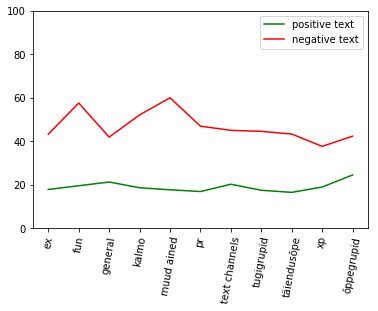

In [5]:
%matplotlib inline
x1, y1 = get_axis_for_emotion("positive", count_group_category)
plt.plot(x1, y1, "g", label='positive text')

x2, y2 = get_axis_for_emotion("negative", count_group_category)
plt.plot(x2, y2, "r", label='negative text')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0, 100))
plt.xticks(rotation=80)
plt.legend()

#### Hinnang: 
- Õppegruppide kanalites on kõige rohkem positiivse alatooniga teksti
- Muude ainete ning fun kanalites on kõige rohkem negatiivse alatoniga teksti (nagu ka 2019 aasta java serveris)
- Programmeerimine jätab vähem halva enesetunde võrreldes kanalites muude tegevustega

<IPython.core.display.Javascript object>


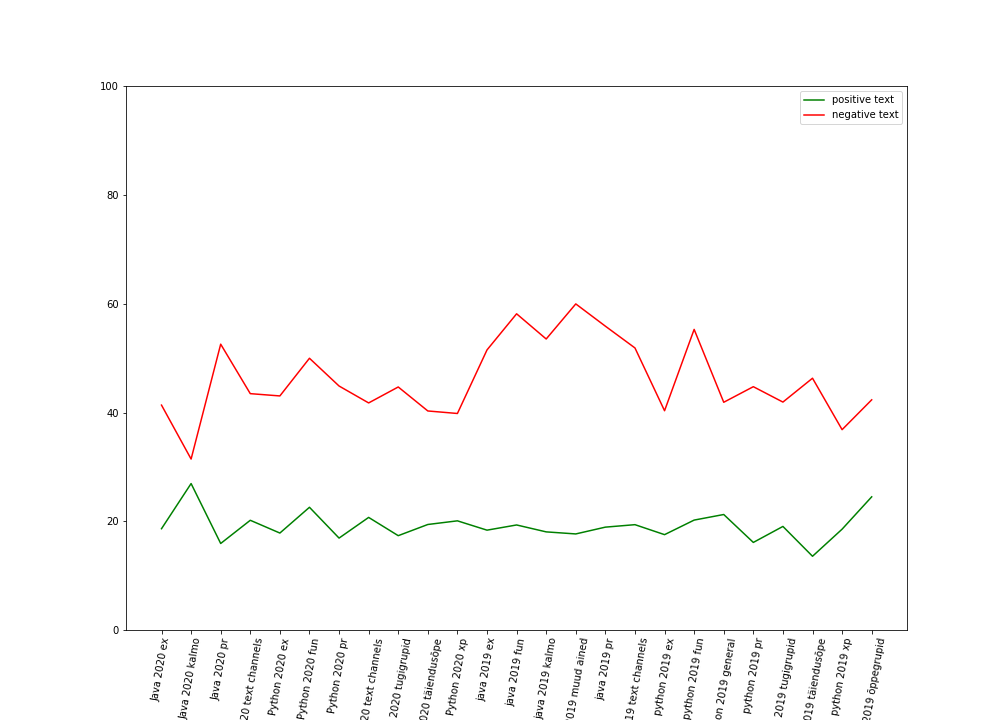

In [14]:
%matplotlib notebook
x1, y1 = get_axis_for_emotion("positive", count_year_channels)
plt.plot(x1, y1, "g", label='positive text')

x2, y2 = get_axis_for_emotion("negative", count_year_channels)
plt.plot(x2, y2, "r", label='negative text')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0, 100))
plt.xticks(rotation=80)
plt.legend()
plt.rcParams["figure.figsize"]=14,10

#### Hinnang: 
- Java 2020 Kalmo kanalites on rohkem positiivse alatooniga teksti
- Python 2019 õppegruppide kanalites on samuti palju positiivse alatooniga teksti
- Süvapüütoni ülesanded jätavad tudengid emotsionaalselt külmaks
- Fun kanalid on läbivalt suhteliselt negatiivse alatooniga
- Python 2019 täiendusõpe polnud positiivne kogemus

<IPython.core.display.Javascript object>


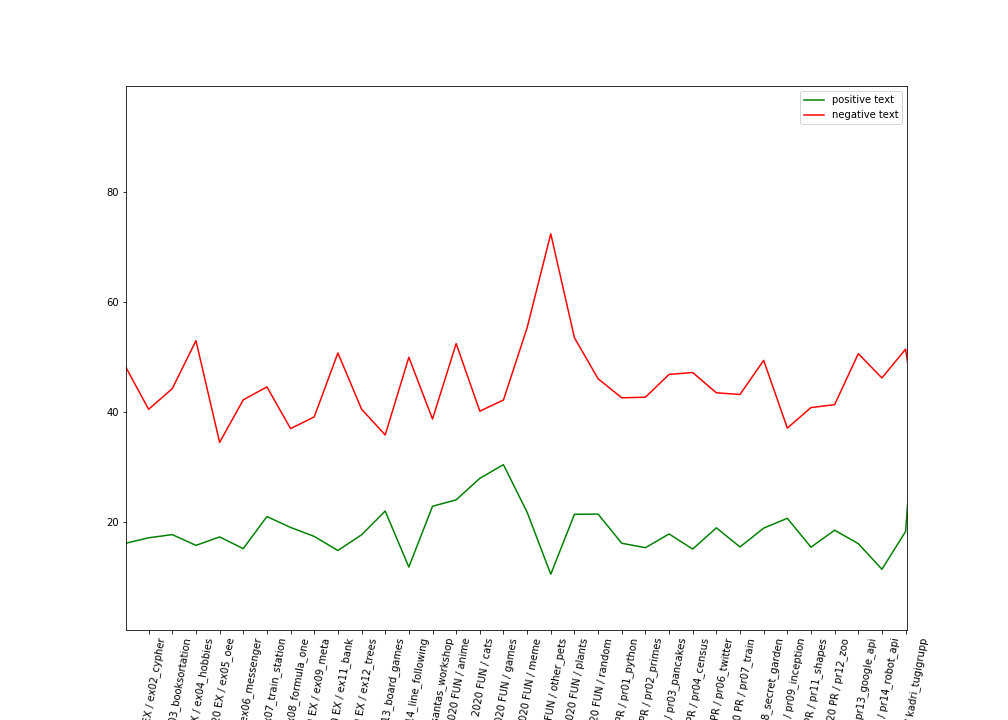

In [31]:
%matplotlib notebook
x1, y1 = get_axis_for_emotion("positive", count_flat)
plt.plot(x1, y1, "g", label='positive text')

x2, y2 = get_axis_for_emotion("negative", count_flat)
plt.plot(x2, y2, "r", label='negative text')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0, 100))
plt.xticks(rotation=80)
plt.legend()
plt.rcParams["figure.figsize"]=14,10

#### Hinnang: 
- Mingil põhjusel other_pets kanalis on väga palju negatiivse alatooniga teksti
- Emoji'sid pole arvesse võetud
- Ülesannetest ex14, ex11 ning ex04 olid kõige negatiivsema alatooniga kanalid
- Ülesannetest ex07, ex13 ja ex15 olid kõige positiivsema alatooniga kanalid

#### ConcatConfiguration

ConcatConfiguration paneb kokku sõnumid, et saaks teisi analüsaatoreid kasutada

In [7]:
%%capture
concat_configuration = ConcatConfiguration()
concat_runner = CachedRunner(concat_configuration)
concat_matrixes = concat_runner.get_datasets(fresh=False)

concat_all = concat_matrixes[0]
concat_year = concat_matrixes[1]
concat_year_channels = concat_matrixes[2]
concat_flat = concat_matrixes[3]
concat_group_category = concat_matrixes[4]

#### QuantitativeMetrics
QuantitativeMetrics hindab sisendteksti:
- loetavust
- keerukust
- tihedust
- formaalsust

In [8]:
quantitative_metrics_table = QuantitativeMetrics().analyze(concat_year_channels)

In [9]:
display(quantitative_metrics_table)

,group,fres,gunning_fog,lexical_density,formality
0,Java 2020 ex,53.69,15.32,41.30,38.91
1,Java 2020 kalmo,49.30,15.90,42.90,40.87
2,Java 2020 pr,54.67,14.75,40.27,40.14
3,Java 2020 text channels,54.97,14.62,41.23,39.09
4,Python 2020 ex,55.09,14.71,41.55,39.34
5,Python 2020 fun,57.83,14.71,38.52,39.45
6,Python 2020 pr,58.13,13.88,40.64,38.80
7,Python 2020 text channels,58.05,13.73,41.56,39.09
8,Python 2020 tugigrupid,59.40,13.80,40.64,39.84
9,Python 2020 täiendusõpe,60.21,12.99,39.46,37.15


In [24]:
quantitative_metrics_table_flat = QuantitativeMetrics().analyze(concat_flat)

<IPython.core.display.Javascript object>


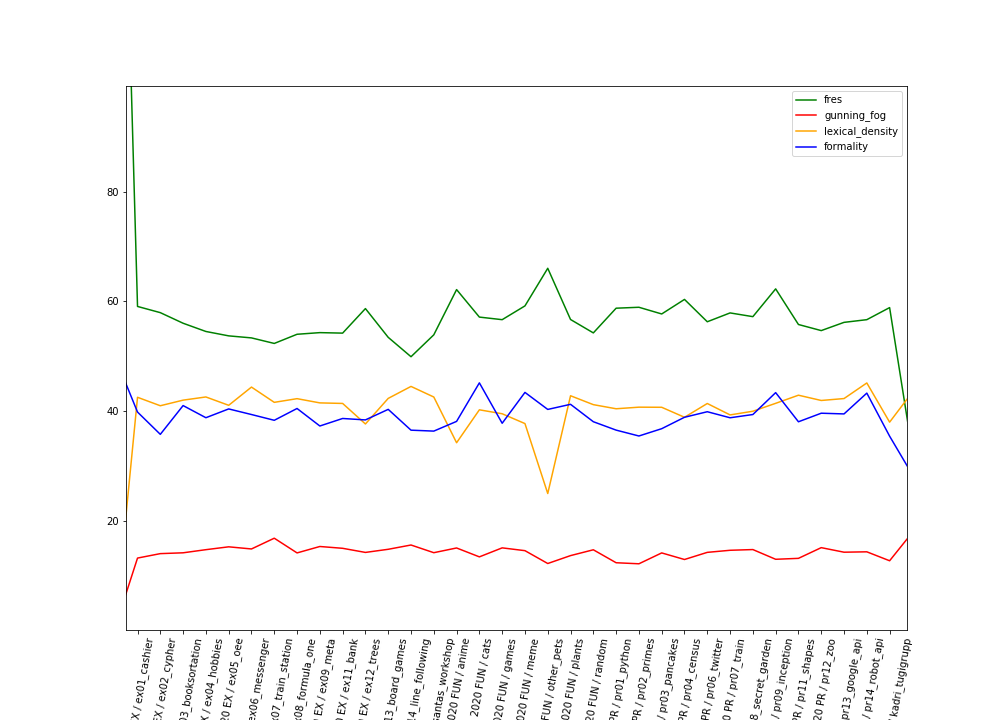

In [30]:
%matplotlib notebook
x = quantitative_metrics_table_flat["group"]
y1 = quantitative_metrics_table_flat["fres"]
y2 = quantitative_metrics_table_flat["gunning_fog"]
y3 = quantitative_metrics_table_flat["lexical_density"]
y4 = quantitative_metrics_table_flat["formality"]

# 100 on loetav
plt.plot(x, y1, "g", label='fres')

# 100 on keeruline
plt.plot(x, y2, "r", label='gunning_fog')

# 100 on tihe
plt.plot(x, y3, "orange", label='lexical_density')

# 100 on formaalne
plt.plot(x, y4, "b", label='formality')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, 0, 100))
plt.xticks(rotation=80)
plt.legend()
plt.rcParams["figure.figsize"]=14,10

#### Hinnang: 

FRES
 - loomade kanalid on loetavad
 - PR ülesannetest PR09 ning PR04 olid loetavad
 - EX ülesannetest EX12 oli loetav ning EX14 oli vähe loetav

Gunning FOG
 - Kõik ülesande kanalid olid sama suure keerukusega

Leksikaalne tihedus
 - other_pets kanal on väga hõre
 - teised kanalid on aga suuresti sama tihedad

Formaalsus
 - cats, PR09 ning PR14 kanalid on kõige formaalsemad kanalid

In [10]:
import numpy as np
import itertools

matrix = [
    ("FRES", quantitative_metrics_table["fres"]),
    ("GFOG", quantitative_metrics_table["gunning_fog"]),
    ("Density", quantitative_metrics_table["lexical_density"]),
    ("Formality", quantitative_metrics_table["formality"])
]

print("Correlations between:")
for (name1, list1), (name2, list2) in itertools.product(matrix, repeat = 2):
    print(name1 + " and " + name2 + " are " + str(abs(round(np.corrcoef(list1, list2)[0, 1], 2))))

Correlations between:
FRES and FRES are 1.0
FRES and GFOG are 0.89
FRES and Density are 0.71
FRES and Formality are 0.59
GFOG and FRES are 0.89
GFOG and GFOG are 1.0
GFOG and Density are 0.55
GFOG and Formality are 0.67
Density and FRES are 0.71
Density and GFOG are 0.55
Density and Density are 1.0
Density and Formality are 0.3
Formality and FRES are 0.59
Formality and GFOG are 0.67
Formality and Density are 0.3
Formality and Formality are 1.0


#### Hinnang: 
- Meetrikad on suuresti korrelatsioonis v.a teksti tihedus ja formaalsus

#### TextRankAnalyzer
TextRankAnalyzer ekstrahheerib võtmesõnad ning sisukokkuvõtted

In [11]:
textrank_table = TextRankAnalyzer().analyze(concat_flat)

In [12]:
pd.set_option('display.max_colwidth', -1)
display(textrank_table)
pd.reset_option('display.max_colwidth')

,group,group_members,summary,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10,keyword_11,keyword_12,keyword_13,keyword_14,keyword_15,keyword_16,keyword_17,keyword_18,keyword_19
0,Java 2020 Kalmo / java,['Java 2020 Kalmo / java'],"}```, kuid annab teate, et ""method does not override method from its superclass"" ning "" method equals(oo.hide.Point) is never used"" kas keegi oskab seletada, mis on selle testi esimese rea mõte, kuidas see töötab ja miks ta võib mul feilida?",java,javat,eksam,equals,loeng,commit,test ülesanne aine,küsimus,lambda,idea,idee,kood,klass meetod,juht,metho,tester,https,array,getparameter,
1,Java 2020 PR / pr01-introduction,['Java 2020 PR / pr01-introduction'],kas see 2 ei peaks olema?\naa see on O.\nma vaatasin et see on 0.\nhttps://ained.ttu.ee/javadoc/data_structures/list.html.\noota kas Array ja ArrayList on sama asi?\nEi. https://ained.ttu.ee/javadoc/data_structures/array.html.\npushisin koodi giti aga ained.ttul ei ole vastust tulnud.\nsul on failinimi väikese tähega.\naga tester on linux.,kood,täht,list,arraylist,nimi,datastructure,ained,https,kord seotud windowsi failisysteem case insensitive tester,introduction,necessary,,,,,,,,,
2,Java 2020 PR / pr02-datastructures,['Java 2020 PR / pr02-datastructures'],"Üllis on kirjas, et kui sõne esineb listis paaritu number korda, siis jätta seda vahele, kuigi mallis viimases testis SPAM esineb 3 korda ja seda ikka prinditakse.\n@KiDDY , sul on tulemuses kaks elementi: ""story, Book"" ja ""]["".\nTänud, hoopis lihtsam asi nüüd 🙂 Kas elementide järjekord listis on oluline?",list,variant,järjekord,kord,java,kood,story,tulemus element,test,sõnum probleem whitespace,tänu,olev raamat,testonlyeven järjekorratundlik kiri,spam,,,,,,
3,Java 2020 PR / pr03-datatypes,['Java 2020 PR / pr03-datatypes'],"jah.\n`Name 'B' must match pattern '^[a-z][a-zA-Z0-9]*$'.` Ei mõista millest see tekib.\nbB.\nnimeta B bB.\nmod 8!\nmod 8!\nAitäh sulle @Kadri, nii kasulik sisend siia vestlusesse!\nMuidu jah, mõeldud ikka Math.pow(x).\nÜmardist pole vaja jah.\nmod 8!\nmis tähendab see mod?\nmod = % = jääk.",java,mõeldud,ülesanne olev viide javadoc leht vigane fiksisin sponsor task stackoverflowexception must match pattern,progeb,jumme nimi,pepel tehe,,,,,,,,,,,,,,
4,Java 2020 PR / pr04-subclasses,['Java 2020 PR / pr04-subclasses'],"Juhul kui kujund ei sisalda numbrit peab getNumber() tagastama Optional.empty().\nMeil on size, mis on siis raadius ja külje pikkus kummaski klassis, aga mis see number on.\nkui on int, siis ei saa null olla.\nmida rohkem, seda uhkem 🙂 hoopis parem, tänud 🙂 Ma ei muutnud midagi veel :D.",number,enum,optional,optionali,funktsioon,tänu,message,juht,kujund,täht,kontroll,uni antsar,getcategory string faile,baby developer lisa,input,,,,,
5,Java 2020 PR / pr06-reading-files,['Java 2020 PR / pr06-reading-files'],"2) Sinu küsimuse vastus on see, et pane neile tegevustele lihtsalt try catch(IOException) ümber, siis ei pea meetodi signatuuri muutma Pmst sarnaselt nagu selles näites: Jah, siin ülesandes piisab kui panna try catch über kohtades, kus IntelliJ seda nõuab, kuid testides ei tohiks korrektse koodi korral kood kunagi catch ploki sisse jõuda.",catch,test,ülesanne exceptionite,exceptioni,exception,readfiles meetod kord,näide,setfiletorida fail,intellij,file,reader,selge,readnextline hetk,push,tehtud,aine,,,,
6,Java 2020 PR / pr07-stream,['Java 2020 PR / pr07-stream'],"java.lang.AssertionError: expected: but was:\nKus probleem siin on?\nVabandus, polnud kohal 🙂 `java.lang.AssertionError: expected:<Optional[ee.taltech.iti0200.stream.Kitten@7b66322e]> but was:<Optional.empty>` See on tegelik error.\n@teacher Paluks tagasisidet `testFindFirstKittenWithGivenName` vea kohta, uniid=`eepuud` Ma pole teacher, aga sul võib olla selles viga.\n@karkat aitäh, ei näinud seda, aga mul läks nüüd läbi.\nAitäh, see lahendas probleemi 🙂",teacher,viga,java expecte nothing,probleem,testfindfirstkittenwithgivenname,b tegel

#### Hinnang: 
- Üldiselt nende ülesannete kanalites võtmesõnad viitavad ülesande sisule (seal õpetatavatele teemadele), sest tudengid küsivad nende kohta küsimusi ja saavad vastuseid
- Võtmesõnad, mis viitavad ülesande teemale/tekstile on ka esile toodud
- Sisukokkuvõtted võtavad üllatavalt hästi kanali kokku

#### TfidfVectorizer
TfidfVectorizer klasterdab tekstid ning tagastab tihti koosesinevad sõnad

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score


def print_keywords_per_cluster(k, documents):
    stop_words = set(['a', 'abil', 'aegu', 'aga', 'ainult', 'alalt', 'alates', 'alati', 'all', 'alla', 'alles', 'alt', 'asemel', 'b', 'c', 'd', 'e', 'eales', 'ealeski', 'edasi', 'eelmine', 'eemal', 'ees', 'eest', 'ega', 'ehk', 'ehkki', 'ei', 'emb-kumb', 'enam', 'end', 'enda', 'endine', 'enese', 'enim', 'enne', 'ennem', 'ent', 'esimene', 'esimest', 'et', 'etem', 'ette', 'f', 'g', 'h', 'halb', 'halvasti', 'halvim', 'hea', 'hiljem', 'hoopis', 'hulga', 'hulgas', 'hulk', 'hästi', 'i', 'iga', 'igal', 'igamees', 'iganes', 'igavesti', 'igaüks', 'iial', 'iialgi', 'ikka', 'ilma', 'ilmaski', 'ise', 'iseenda', 'iseenese', 'isegi', 'j', 'ja', 'jooksul', 'ju', 'juba', 'juhul', 'just', 'justkui', 'juures', 'järelikult', 'järgi', 'järgmine', 'k', 'ka', 'kahe', 'kaheksa', 'kaheksandat', 'kaheksat', 'kahte', 'kaks', 'kallal', 'kaudselt', 'kaudu', 'kaugel', 'keda', 'keegi', 'kehva', 'kehvem', 'kelle', 'kellega', 'kelleks', 'kellel', 'kellele', 'kellelt', 'kellena', 'kelleni', 'kelles', 'kellesse', 'kellest', 'kelleta', 'kes', 'kestahes', 'kestel', 'kogu', 'kohta', 'kokku', 'kolm', 'kolmandat', 'kolmas', 'kolme', 'koos', 'kord', 'kuhu', 'kui', 'kuid', 'kuidagi', 'kuidas', 'kuigi', 'kuivõrd', 'kumb', 'kumbki', 'kuna', 'kuni', 'kus', 'kust', 'kuue', 'kuuendat', 'kuus', 'kuute', 'kõige', 'kõik', 'kõrval', 'käes', 'küll', 'kümme', 'kümmet', 'kümne', 'kümnendat', 'küüsis', 'l', 'ligi', 'ligidal', 'lisaks', 'läbi', 'lähedal', 'm', 'ma', 'me', 'meelest', 'meid', 'meie', 'meiega', 'meieks', 'meiena', 'meieni', 'meieta', 'meil', 'meile', 'meilt', 'meis', 'meisse', 'meist', 'mida', 'midagi', 'mihuke', 'mihukene', 'mil', 'millalgi', 'mille', 'millega', 'milleks', 'millel', 'millele', 'millelt', 'millena', 'milleni', 'milles', 'millesse', 'millest', 'milleta', 'milline', 'mina', 'mind', 'mingi', 'mingisugune', 'minu', 'minuga', 'minuks', 'minul', 'minule', 'minult', 'minuna', 'minuni', 'minus', 'minusse', 'minust', 'minuta', 'mis', 'miski', 'miskisugune', 'mispärast', 'missugune', 'mistahes', 'misuke', 'mitmendik', 'mitmes', 'mitte', 'mitu', 'mu', 'mulle', 'mult', 'muu', 'muudkui', 'mõlema', 'mõlemad', 'mõnda', 'mõne', 'mõnelt', 'mõnes', 'mõni', 'mõningane', 'määrane', 'mööda', 'n', 'naasugune', 'nad', 'nagu', 'najal', 'natuke', 'natukese', 'natukeseks', 'need', 'neid', 'neiks', 'neil', 'neile', 'neilt', 'neis', 'neisse', 'neist', 'neli', 'nelja', 'neljandat', 'nemad', 'nende', 'nendega', 'nendeks', 'nendele', 'nendelt', 'nendena', 'nendeni', 'nendes', 'nendesse', 'nendest', 'nendeta', 'nendel', 'nigu', 'nihuke', 'nii', 'niikaua', 'niisamasugune', 'niisugune', 'ning', 'nõnda', 'nüüd', 'o', 'ole', 'oleks', 'olgu', 'olgugi', 'oli', 'olla', 'olnud', 'oma', 'on', 'osa', 'otsa', 'otsekui', 'p', 'paar', 'paarkümmend', 'paarsada', 'palju', 'parem', 'paremal', 'parim', 'peaks', 'peal', 'peale', 'peamiselt', 'pigem', 'pihta', 'pisut', 'pole', 'poleks', 'poole', 'poolest', 'praegu', 'praegune', 'puhul', 'päralt', 'pärast', 'päris', 'r', 'ringis', 'rohkem', 's', 'sa', 'saa', 'saadik', 'saatel', 'sama', 'samasugune', 'samuti', 'seal', 'seda', 'see', 'seega', 'sees', 'seesama', 'seesamane', 'seesamune', 'seesugune', 'seitse', 'seitset', 'seitsme', 'seitsmendat', 'sel', 'selle', 'sellepärast', 'selletaoline', 'selline', 'seltsi', 'seni', 'sest', 'sestap', 'sihuke', 'sihukene', 'siin', 'siis', 'siiski', 'sina', 'sind', 'sinu', 'sinuga', 'sinuks', 'sinule', 'sinult', 'sinuna', 'sinuni', 'sinus', 'sinusse', 'sinust', 'sinuta', 'sisse', 'siuke', 'siukene', 'suht', 'suhtes', 'sulle', 'sult', 'suur', 'säherdune', 'säärane', 'š', 'z', 'ţ', 't', 'ta', 'taga', 'tagant', 'tagasi', 'taha', 'tal', 'talle', 'talt', 'taoline', 'te', 'tea', 'teda', 'teel', 'teid', 'teie', 'teiega', 'teiena', 'teieni', 'teieta', 'teiks', 'teil', 'teile', 'teilt', 'teine', 'teineteise', 'teis', 'teisse', 'teist', 'teistsugune', 'tema', 'temaga', 'temaks', 'temal', 'temale', 'temalt', 'temana', 'temani', 'temas', 'temasse', 'temast', 'temata', 'terve', 'toda', 'toetub', 'toetudes', 'tohutu', 'tol', 'tolle', 'too', 'toosama', 'toosamane', 'tugineb', 'tuginedes', 'tõhusam', 'tõttu', 'täiesti', 'tänu', 'u', 'umbes', 'uue', 'uuega', 'uuelt', 'uuema', 'uuemaga', 'uuemal', 'uuemale', 'uuemalt', 'uuemana', 'uuemas', 'uuemasse', 'uuemast', 'uuena', 'uues', 'uuest', 'uus', 'v', 'w', 'vahel', 'vaid', 'valla', 'vana', 'vanaga', 'vanalt', 'vanana', 'vanas', 'vanast', 'vanema', 'vanemaga', 'vanemal', 'vanemale', 'vanemalt', 'vanemana', 'vanemas', 'vanemasse', 'vanemast', 'varal', 'varem', 'vasak', 'vasakul', 'vastu', 'veel', 'veidi', 'viie', 'viiendat', 'viis', 'viisi', 'viite', 'või', 'võib', 'võib-olla', 'võidu', 'võiks', 'võrra', 'väel', 'väga', 'vähe', 'vähem', 'vähemalt', 'väike', 'välja', 'väljas', 'vältel', 'õ', 'ä', 'ära', 'äärde', 'ääres', 'ö', 'ü', 'ühe', 'üheksa', 'üheksandat', 'üheksat', 'ühte', 'üks', 'üksi', 'ükski', 'üksteist', 'ülal', 'ülale', 'ülalt', 'üle', 'üles', 'ülesse', 'üleval', 'ülevalt', 'ülimalt', 'ümber', 'x', 'y'])

    vectorizer = TfidfVectorizer(stop_words=stop_words)
    X = vectorizer.fit_transform(documents)

    model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
    model.fit(X)

    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(k):
        print("Cluster " + str(i) + ":")
        for ind in order_centroids[i, :10]:
            print(terms[ind], end=" ")
        print()

In [79]:
print_keywords_per_cluster(15, textrank_table["summary"])

Cluster 0:
sul bonusbalance negatiivne pointer teki this vihjest exceptionit skipped näe 
Cluster 1:
loope rekursiooni tohi kasutada mul ül üli iseenesest lahendamiseks lahendanud 
Cluster 2:
kas mul teha aru saab saan jah olen tuleb sul 
Cluster 3:
_name kasutad tohiks completida ide person1 ülesehitust getterist peitmise loogika 
Cluster 4:
vahearuanne päeva päevadel basic koloniseerima vahearuandeid koloniseerimine vahearuannetega idee mainin 
Cluster 5:
reaktsioon tk abi läheb vaja seisuga punktidele visake hetke suurepäraselt 
Cluster 6:
kirjutada lisatud võite küsimustele spetsiifilisem ülevaade vastata olete põhimõtteliselt kiiresti 
Cluster 7:
sai mallist ingliskeelne oskakski tuua ülesandekirjeldus loetud näited tulidki vead 
Cluster 8:
pilt build django dir valiku jõuab pipi uuendus dj tutoriali 
Cluster 9:
1000 как можно этом но рандомно раз работы предлагается после 
Cluster 10:
else kunagi blokki lähegi is_valid_id tänan id_code isdigit vastuseks ilmneb 
Cluster 11:
olema 

/opt/conda/envs/estnltk/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [78]:
print_keywords_per_cluster(15, concat_flat["text"])

/opt/conda/envs/estnltk/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Cluster 0:
figures drawing drawingfullerror figure raise erindi self exception dc exceptioni 
Cluster 1:
kas jah teha saab aleksei mul vist aine kt kell 
Cluster 2:
watch youtube www https com youtu be エンデル muusika lugu 
Cluster 3:
999 else ms isdigit failed 2004 if skipib undefined literal 
Cluster 4:
10153 5247616 8768811 crying stressed tenor gif cry view wave 
Cluster 5:
kas jah mul teha vist saab ago kadri no https 
Cluster 6:
kas mul jah teha sul saab aru olema vist tuleb 
Cluster 7:
idcode gender java kas male isidcodecorrect female int final magic 
Cluster 8:
testfindfirstkittenwithgivenname nothing expected optional 7b66322e lang kitten was alrudo assertionerror 
Cluster 9:
sentence s1 s2 equals test kas junit testing testi pr03 
Cluster 10:
295 maksuga 20 käibemaksu gettotalsales salesrecords i1 records maha kalkulaator 
Cluster 11:
jaa ɐɐſ yaa jaaaa hahah toimub jah 𝘔𝘪𝘬𝘬uga kattsin kattis 
Cluster 12:
githubi django githubist avatari pipenv bin snuserino pillow avatar repo 


#### Hinnang: 

Peamised huvitavad klastrid, mis tekkisid on järgmised:
 - loop, rekursioon
 - graafikud, erindid
 - youtube, videod, muusika
 - numbrid, numbritega seotud erindid
 - pildid
 - erindid
 - testimine
 - raha
 - git
 - taimed
 - moodle
 - dokumentatsioon
 - vene keel
 - python
 - ülesanded, mall